In [45]:
# Import libraries
import os
import sys

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statistics
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [2]:
# Check virtual environment: should be: '/Users/James/anaconda3/envs/mimic/bin/python'
sys.executable

'/Users/James/anaconda3/envs/mimic/bin/python'

In [3]:
# Set up paths
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_folder = os.path.join(project_root, 'src')

src_preparation_folder = os.path.join(src_folder, 'preparation')
src_processing_folder = os.path.join(src_folder, 'processing')

In [4]:
# Import src functions
sys.path.insert(0, src_preparation_folder)
from import_data import get_table
from import_data import get_patient_admissions_diagnoses
from import_data import get_admission_data
from import_data import get_chartevents
from import_data import get_labevents
from extract_codes import find_ndc_codes

sys.path.insert(0, src_processing_folder)
from stats import plot_KDE
from stats import plot_perc_bar_chart
from stats import compare_groups

In [5]:
# Get subjects that were diagnoses with Alzheimers
subjects = get_table(host = 'localhost',
                  dbname = 'mimic',
                  schema = 'mimiciii',
                  table = 'diagnoses_icd',
                  columns = 'DISTINCT subject_id',
                  where = "icd9_code ='3310'").subject_id.tolist()
print(len(subjects))

503


In [6]:
# Get a random sample of patients (not in original subject list)
base = get_table(host = 'localhost',
                  dbname = 'mimic',
                  schema = 'mimiciii',
                  table = 'patients',
                  columns = 'DISTINCT subject_id',
                  where = "subject_id NOT IN {} AND subject_id > 0".format(tuple(set(subjects)))).subject_id.tolist()
print(len(base))
base = [base[i] for i in sorted(random.sample(range(len(base)), 20000))]
len(base)

46017


20000

In [7]:
# Get patient, admission and diagnosis data for these subjects
group = get_patient_admissions_diagnoses(subjects)
print(group.shape)

base_group = get_patient_admissions_diagnoses(base)
print(base_group.shape)

(9822, 21)
(277763, 21)


In [8]:
# --- Create lists of admissions to compare in each group

# From subjects keep only cases where it was their first admission and they were diagnosed with Alz on this admission
subject_adm = group[(group['admission_number'] == 1) & (group['diagnosis_icd9'] == '3310')].hadm_id.unique().tolist()
print(len(subject_adm))

# Keep only first admissions of base group, and remove newborns
base_adm = base_group[(base_group['admission_number'] == 1)
                      & (base_group['admission_type'] != 'NEWBORN')].hadm_id.unique().tolist()
print(len(base_adm))

450
16555


/Users/James/Desktop/YourMD/machine_learning/mimic/src/processing/stats.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.dropna(inplace=True)


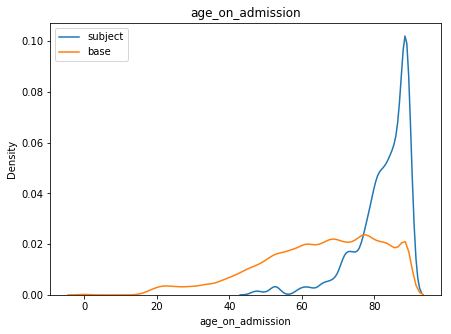

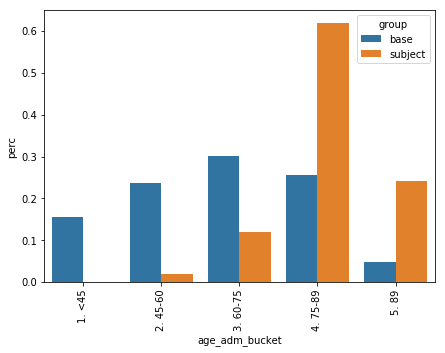

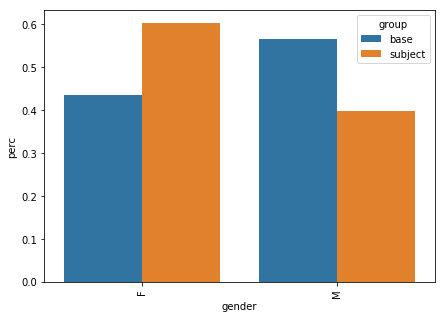

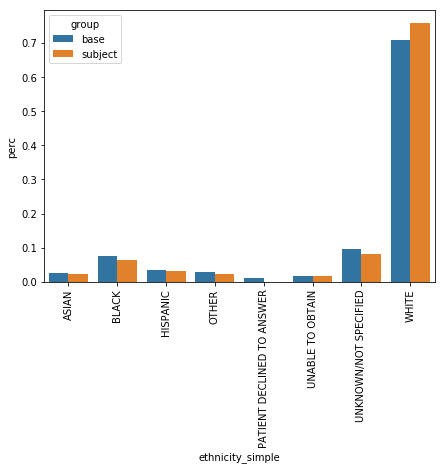

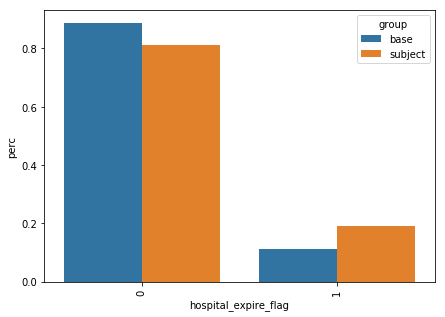

,subject_id,group,gender,age_on_admission,age_adm_bucket,ethnicity,ethnicity_simple,diagnosis_name,hospital_expire_flag
0,72402,subject,M,79,4. 75-89,WHITE,WHITE,Urinary obstruction NEC,0
1,72402,subject,M,79,4. 75-89,WHITE,WHITE,"Subendo infarct, initial",0
2,72402,subject,M,79,4. 75-89,WHITE,WHITE,Food/vomit pneumonitis,0
3,72402,subject,M,79,4. 75-89,WHITE,WHITE,Ac on chr diast hrt fail,0
4,72402,subject,M,79,4. 75-89,WHITE,WHITE,Ac DVT/emb prox low ext,0
5,72402,subject,M,79,4. 75-89,WHITE,WHITE,"Dysphagia, oropharyngeal",0
6,72402,subject,M,79,4. 75-89,WHITE,WHITE,Urin tract infection NOS,0
7,72402,subject,M,79,4. 75-89,WHITE,WHITE,Pulm embol/infarct NEC,0
8,72402,subject,M,79,4. 75-89,WHITE,WHITE,Hy kid NOS w cr kid I-IV,0
9,72402,subject,M,79,4. 75-89,WHITE,WHITE,Chr pulmon heart dis NEC,0


In [9]:
# Compare the two populations
compare_groups(subjects=subject_adm, base=base_adm)

312
4148


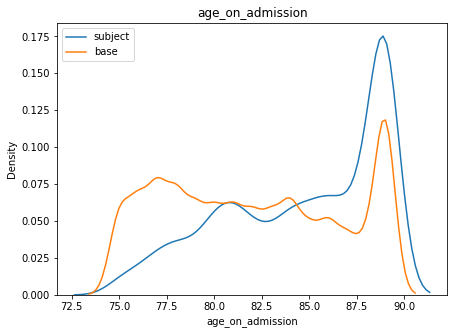

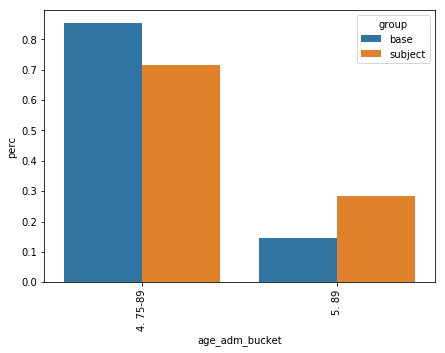

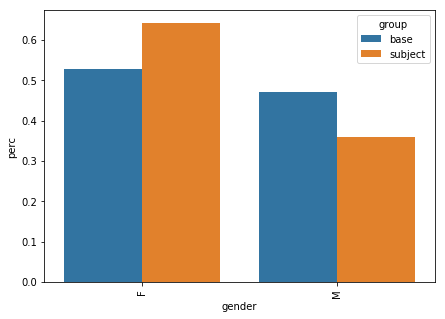

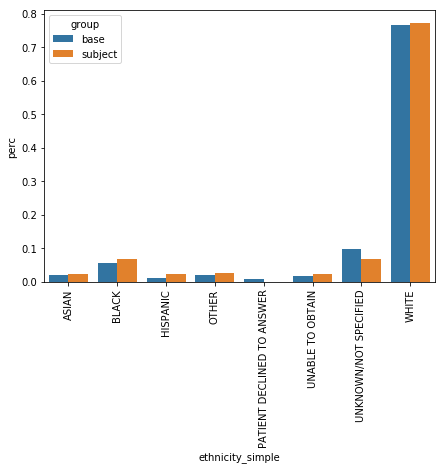

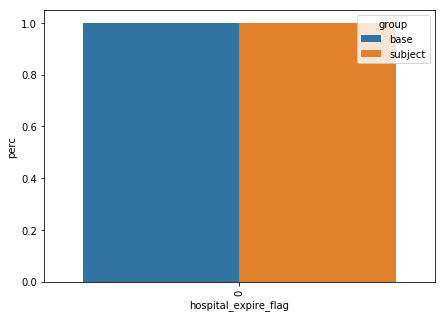

,subject_id,group,gender,age_on_admission,age_adm_bucket,ethnicity,ethnicity_simple,diagnosis_name,hospital_expire_flag
0,24731,subject,F,81,4. 75-89,WHITE,WHITE,Anemia NOS,0
1,24731,subject,F,81,4. 75-89,WHITE,WHITE,Sepsis,0
2,24731,subject,F,81,4. 75-89,WHITE,WHITE,Hx of breast malignancy,0
3,24731,subject,F,81,4. 75-89,WHITE,WHITE,Comp-oth vasc dev/graft,0
4,24731,subject,F,81,4. 75-89,WHITE,WHITE,Spinal stenosis NOS,0
5,24731,subject,F,81,4. 75-89,WHITE,WHITE,Crnry athrscl natve vssl,0
6,24731,subject,F,81,4. 75-89,WHITE,WHITE,Abn react-procedure NEC,0
7,24731,subject,F,81,4. 75-89,WHITE,WHITE,Pleural effusion NOS,0
8,24731,subject,F,81,4. 75-89,WHITE,WHITE,Accid in resident instit,0
9,24731,subject,F,81,4. 75-89,WHITE,WHITE,Septicemia NOS,0


In [10]:
# To crudely make the samles more similar, only accept patients from both groups who are >= 75, then re-compare
# Adittionally, remove all patients who died in order for a final reading of vital signs to be taken

# From subjects keep only cases where it was their first admission and they were diagnosed with Alz on this admission
subject_adm = group[(group['admission_number'] == 1)
                    & (group['diagnosis_icd9'] == '3310')
                    & (group['age_on_admission'] >= 75)
                    & (group['hospital_expire_flag'] == 0)].hadm_id.unique().tolist()
print(len(subject_adm))

# Keep only first admissions of base group, and remove newborns
base_adm = base_group[(base_group['admission_number'] == 1)
                      & (base_group['admission_type'] != 'NEWBORN')
                      & (base_group['age_on_admission'] >= 75)
                      & (base_group['hospital_expire_flag'] == 0)].hadm_id.unique().tolist()
print(len(base_adm))

compare_groups(subjects=subject_adm, base=base_adm)

## Take the final measurement of each vital sign for patients in each admission group

In [35]:
# Take a single admissission list and list indicating the group
adm_full = subject_adm + base_adm
s_l = [1] * len(subject_adm)
b_l = [0] * len(base_adm)
labels = s_l + b_l

In [12]:
chart = get_chartevents(host = 'localhost',
                      dbname = 'mimic',
                      admissions = adm_full,
                      reading = 'MAX')

In [13]:
lab = get_labevents(host = 'localhost',
                          dbname = 'mimic',
                          admissions = adm_full,
                          reading = 'MAX')

In [36]:
# Pivot the data so there's 1 column per chart/ lab event
events_df = chart.append(lab)
events_df=pd.pivot_table(events_df, values='valuenum', index=['subject_id', 'hadm_id'], columns='itemid')
events_df=events_df.reset_index()

# Create lookup and merge labels onto chart DF
lookup = pd.DataFrame(columns=['hadm_id', 'target'])
lookup['hadm_id'] = adm_full
lookup['target'] = labels
events_df = pd.merge(events_df, lookup, how='left', left_on='hadm_id', right_on='hadm_id')
events_df.head()

,subject_id,hadm_id,24,25,26,28,29,35,50,51,...,228379,228380,228394,228395,228396,228409,228410,228411,228412,target
0,21,109451,NaN,NaN,NaN,NaN,-55.0,NaN,NaN,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,30,104557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,34,115799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,63,195961,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,75,112086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [37]:
# Clean data ready for model
features = events_df.drop(columns=['subject_id', 'hadm_id', 'target'])
labels = events_df.target.tolist()

# Impute missing values
imputer = Imputer(strategy = 'median')
imputer.fit(features)
features = imputer.transform(features)

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1)) 
scaler.fit(features)
features = scaler.transform(features)

/Users/James/anaconda3/envs/mimic/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [54]:
# Model
# TRAIN A LGBM

def model(features, labels, n_folds):
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    print('LGB starting')
        
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features  = features[train_indices]
        train_labels = [x for i,x in enumerate(labels) if i in train_indices]
        # Validation data for the fold
        valid_features = features[valid_indices]
        valid_labels = [x for i,x in enumerate(labels) if i in valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier( metric='auc',
                                    nthread=4,
                                    n_estimators=10000,
                                    learning_rate=0.01,
                                    num_leaves=10,
                                    colsample_bytree=0.9497036,
                                    subsample=0.8715623,
                                    max_depth=8,
                                    reg_alpha=1,
                                    reg_lambda=1,
                                    min_split_gain=0.0222415,
                                    min_child_weight=39.3259775,
                                    silent=-1,
                                    verbose=-1)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds = 100, verbose = 100)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return metrics

In [55]:
model(features = features,
    labels = labels,
    n_folds = 5)

LGB starting
Training until validation scores don't improve for 100 rounds.
[100]	valid's auc: 0.643834	train's auc: 0.803642
Early stopping, best iteration is:
[28]	valid's auc: 0.658188	train's auc: 0.777288
Training until validation scores don't improve for 100 rounds.
[100]	valid's auc: 0.631731	train's auc: 0.789069
[200]	valid's auc: 0.662455	train's auc: 0.814769
[300]	valid's auc: 0.689101	train's auc: 0.835693
[400]	valid's auc: 0.694928	train's auc: 0.850831
Early stopping, best iteration is:
[354]	valid's auc: 0.695961	train's auc: 0.844739
Training until validation scores don't improve for 100 rounds.
[100]	valid's auc: 0.652163	train's auc: 0.803888
[200]	valid's auc: 0.661107	train's auc: 0.826237
Early stopping, best iteration is:
[176]	valid's auc: 0.663649	train's auc: 0.82194
Training until validation scores don't improve for 100 rounds.
[100]	valid's auc: 0.656926	train's auc: 0.78417
[200]	valid's auc: 0.691257	train's auc: 0.810427
Early stopping, best iteration is

,fold,train,valid
0,0,0.777288,0.658188
1,1,0.844739,0.695961
2,2,0.821940,0.663649
3,3,0.809093,0.698443
4,4,0.798361,0.657336
5,overall,0.810284,0.658948
